# Import Libraries for use

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import date
import plotly.express as px
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from geopy.geocoders import Nominatim
from sklearn.compose import make_column_transformer
from ipywidgets import Dropdown, FloatSlider, IntSlider,interact

# Write a wrangle function to Load and Preprocess Data

In [183]:
#write a wrangle function to obtain data set
def wrangle(filename):
    #Load Data
    df=pd.read_csv(filename)
    
    #Drop nan values
    df.dropna(inplace=True)
    #Drop string value in price
    df=df.drop(df[df['Price']=="POA"].index)
    #Convert price to float
    df['Price']=df['Price'].astype(float)
    
    #Reset DataFrame Index
    df.reset_index(drop=True,inplace=True)
   
    #Create an empty list to hold the latitude and Longtitude
    maparea=[]
    #Obtain unique values of the address (this prevent us from obtain similar location data more than once)
    area=list(df['Location'].unique())
    #instantiate Nominatim class
    geolocator=Nominatim(user_agent = "my_locator")
    #obtain location data and append in the list maparea
    for i in range(len(area)):
        loc=geolocator.geocode(f"{area[i]}",timeout=20)
        maparea.append((loc.latitude, loc.longitude))
    #Populate the Data with the location data i.e., geocode
    df['lat'], df['lon']=(0,0)
    
    for i in df.index:
        df['lat'].iloc[i],df['lon'].iloc[i]=(maparea[area.index(df['Location'].iloc[i])][0],
                             maparea[area.index(df['Location'].iloc[i])][1])
    
    #Splitting Location to City and State
    df['City']=df['Location'].str.split(',',expand=True)[0]
    df['State']=df['Location'].str.split(',',expand=True)[1]
    
    #Convert Seat string to float
    df['Seats']=df['Seats'].str.replace(' Seats','').str.replace(' ','').astype(float).round()
    
    #Convert Door string to float
    df['Doors']=df['Doors'].str.replace(' Doors','').str.replace(' ','').astype(float).round()
    
    #Convert Cylinder Engine to float
    df['CylindersinEngine']=(df['CylindersinEngine']
                             .str.replace(' L','')
                             .str.replace(' cyl','')
                             .astype(float)).round()
    
    #obtain Engine Capacity
    df['Engine']= (df['Engine']
                     .str.split(',',expand=True)[1]
                     .str.replace(' L','')
                     .astype(float)
                     .fillna(0)).round(1)
    
    #Obtain the age of the car
    df['Age(years)']=(date.today().year-df['Year'])
    
    #Convert Fuel consumption per 100 km to Fuel consumption to km
    df['FuelperKm']=(df['FuelConsumption']
                     .str.split(' / ', expand=True)[0]
                     .str.replace(' L','')
                     .astype(float).div(100)).round(3)
    
    #Convert kilometres column to float
    df['Kilometres']= (df['Kilometres']
                       .replace('-','0')
                       .astype(float).round())
    
    #Obtain Exterior colours
    df['ColourExtInt']= df['ColourExtInt'].str.split(' / ', expand=True)[0]
    for column in df.select_dtypes('object').columns:
        mask=(df[column].value_counts()[df[column].value_counts()<5])
        feat=[names for names,value in mask.items()]
        for name in feat:
            df=df.drop(df[df[column]==name].index, axis=0)
   
    #df['State']=df['State'].map({ ' NSW':'New South Wales', 
                                                    #' VIC':'Victoria',
                                                    #' QLD':'Queensland',
                                                    #' SA':'South Australia',
                                                    #' WA':'Western Australia',
                                                    #' ACT': 'Australia Capital Territory',
                                                    #' AU-VIC':'Victoria',
                                                    #' TAS':'Tasmania',
                                                    #' NT':'Northern Territory'})
    #df.drop(['Location'],axis=1,inplace=True)
    #df["Country"]="Australia"
    
    # Drop column with high cardinality and duplicate column 
    #High Cardinal Column
    Columnhead=list(
                    df.select_dtypes(exclude='number').columns
                    [df.select_dtypes(exclude='number').nunique()>70]
                   )
    #Duplicate Column
    Columnhead.append('Year')
    #Add relevant High Cardinal Column
    Columnhead.remove('City')
    
    df.drop(columns=Columnhead,axis=1,inplace=True)
    #Reset DataFrame Index
    df.reset_index(drop=True,inplace=True)
    
    
    return df

# Use Wrangle Function to Load and Clean Data

In [184]:
Data=wrangle('Australian Vehicle Prices.csv')
Data.head()

/var/folders/1p/qxfwymf91bx8xq63_r1658sm0000gn/T/ipykernel_6587/825197702.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'].iloc[i],df['lon'].iloc[i]=(maparea[area.index(df['Location'].iloc[i])][0],


,Brand,Car/Suv,UsedOrNew,Transmission,Engine,DriveType,FuelType,Kilometres,ColourExtInt,CylindersinEngine,BodyType,Doors,Seats,Price,lat,lon,City,State,Age(years),FuelperKm
0,MG,Hatchback,USED,Automatic,2.0,Front,Premium,16.0,Black,4.0,Hatchback,5.0,5.0,19990.0,-33.762885,151.270702,Brookvale,NSW,2.0,0.067
1,Toyota,Commercial,USED,Automatic,3.0,Rear,Diesel,229829.0,White,4.0,Commercial,4.0,2.0,27995.0,-33.863815,151.045243,Lidcombe,NSW,8.0,0.080
2,Nissan,SUV,USED,Automatic,2.0,Front,Unleaded,114301.0,Blue,4.0,SUV,4.0,5.0,21950.0,-31.654036,152.291893,Pendle Hill,NSW,6.0,0.069
3,Ford,Hatchback,USED,Automatic,2.0,Front,Unleaded,94965.0,White,4.0,Hatchback,5.0,5.0,16999.0,-33.740189,150.864836,Blacktown,NSW,8.0,0.062
4,Nissan,SUV,USED,Automatic,2.0,Front,Unleaded,99294.0,Grey,4.0,SUV,4.0,7.0,24490.0,-33.740189,150.864836,Blacktown,NSW,5.0,0.081


# Check for Multicollinearity in Numerical Variable

In [186]:
corr=Data.select_dtypes('number').corr()


<AxesSubplot:>

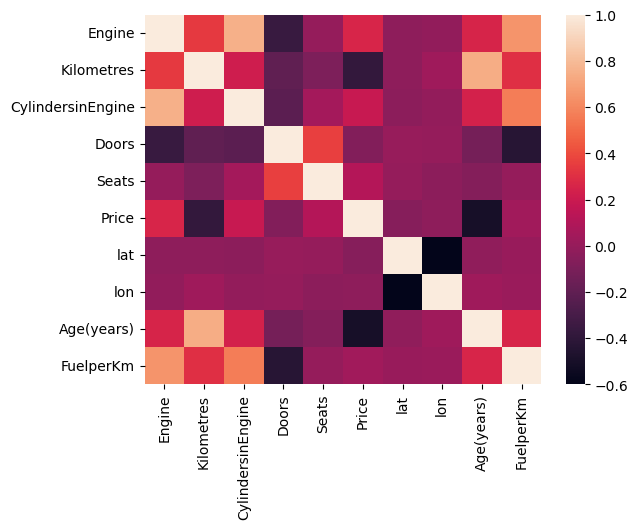

In [188]:
sns.heatmap(corr)

# Identify Target and Train Variable, Split Data Between Train and Test

In [189]:
Data['Age(years)']=Data['Age(years)'].round(0)
# Identify Target and Train Variable
target='Price'
features=['Brand','Kilometres','FuelType','Engine','BodyType','Age(years)']
y=Data[target]
X=Data[features]

#Split Data Between Train and Test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)
X_train

,Brand,Kilometres,FuelType,Engine,BodyType,Age(years)
2964,Holden,95112.0,Diesel,3.0,SUV,6.0
929,Kia,16794.0,Unleaded,3.0,Sedan,4.0
1837,MG,12974.0,Unleaded,2.0,SUV,2.0
1511,Hyundai,50745.0,Unleaded,2.0,Hatchback,5.0
1055,Hyundai,28601.0,Unleaded,2.0,Hatchback,6.0
...,...,...,...,...,...,...
1130,Jeep,187400.0,Diesel,3.0,SUV,11.0
1294,Mazda,98804.0,Unleaded,2.0,Hatchback,10.0
860,Mitsubishi,60972.0,Unleaded,2.0,SUV,5.0
3507,Ford,106249.0,Diesel,3.0,SUV,8.0


# Compute the Baseline Mean Absolute Error

In [190]:
y_tr_mean=y_train.mean()
y_baseline=len(y_train)*[y_tr_mean]
Mae_baseline=mean_absolute_error(y_train,y_baseline)
print(f'Training mean is given as {y_tr_mean.round(2)}')
print(f'Baseline MAE is given as {Mae_baseline.round(2)}')

Training mean is given as 32810.8
Baseline MAE is given as 11015.22


# Instantiate Column Transformer and Onehotencoder for Categorical Variable

In [168]:
Categories=['Brand','FuelType','BodyType']
col_Trans=make_column_transformer((OneHotEncoder(sparse=False),Categories),remainder='passthrough')
col_Trans.fit_transform(X_train).shape


/Users/stephensarumi/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(2944, 40)

# Create pipeline 

In [169]:
model=make_pipeline( col_Trans,
                   Ridge())
model.fit(X_train,y_train)

/Users/stephensarumi/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Brand', 'FuelType',
                                                   'BodyType'])])),
                ('ridge', Ridge())])

In [170]:
y_tr_pred=model.predict(X_train)
MAE_training=mean_absolute_error(y_train,y_tr_pred)
print(f'MAE Training:{MAE_training}')

MAE Training:5164.071048611871


In [171]:
mean_absolute_error(y_test,model.predict(X_test))

5299.645033690066

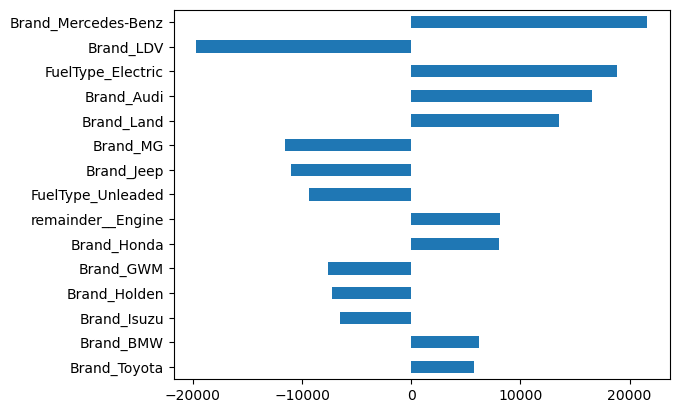

In [177]:
feat_name=model[:-1].get_feature_names_out()
feat_coef=model.named_steps['ridge'].coef_
feat_int=model.named_steps['ridge'].intercept_
feat_imp=pd.Series(feat_coef,index=feat_name)
feat_imp.index=feat_imp.index.str.replace('onehotencoder__','')
feat_imp.sort_values(key=abs).tail(15).plot(kind='barh');

# Prediction Function

In [216]:
def make_prediction(Brand,Kilometres,FuelType,Engine,BodyType,Age):
    data={'Brand':Brand,'Kilometres':Kilometres,'FuelType':FuelType,'Engine':Engine,'BodyType':BodyType,'Age(years)':Age}
    df=pd.DataFrame(data,index=[0])
    if model.predict(df)[0]>0:
        prediction=model.predict(df)[0].round(2)
    else:
        prediction=0
    return prediction


# Interactive Board

In [217]:
interact(make_prediction,
        Brand=Dropdown(options=sorted(X_train['Brand'].unique())),
        FuelType=Dropdown(options=sorted(X_train['FuelType'].unique())),
        BodyType=Dropdown(options=sorted(X_train['BodyType'].unique())),
        Kilometres=IntSlider(min=0,
                             max=X_train['Kilometres'].max()*1.5,
                             value=X_train['Kilometres'].mean()
                  ),
        Engine=FloatSlider(min=0,
                             max=X_train['Engine'].max()*1.5,
                             value=X_train['Engine'].mean()
                  ),
        Age=IntSlider(min=0,
                             max=X_train['Age(years)'].max()*1.5,
                             value=X_train['Age(years)'].mean()
                  ),);

interactive(children=(Dropdown(description='Brand', options=('Audi', 'BMW', 'Chrysler', 'Ford', 'GWM', 'Holden…

In [201]:
make_prediction("Toyota",60000,'Premium',2.0,'Sedan',5)

37492.95697883841

In [203]:
def trim_data(df):
    for column in df.select_dtypes('object').columns:
        mask=(df[column].value_counts()[df[column].value_counts()<5])
        feat=[names for names,value in mask.items()]
        for name in feat:
            df=df.drop(df[df[column]==name].index, axis=0)